# Homework 2: Dijstrka and Ising



#Part 1 - Find your way in Paris


For many of you this is the first year in Paris, one of the most cosmopolitan city in the world. During this homework we will help you building your home-made navigator using the Dijstrka algorith (see [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)).

Moreover you will challenge yourself on how to create nice and readable plots using Python.

## Data loading

By running the below cells, you will download all the required data. You can also download them manually and put them in the same folder of the notebook.

In [1]:
#libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import scipy.optimize

### Map data preparation

Run the cells below to download the data about the map of Paris.

In [2]:
#this are the data used for plotting the map of Paris
#! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/arrondissements-millesimes0.csv"

In [3]:
# run this code to create a list of the coordinates of the different arrondissements of Paris
arrondis = pd.read_csv("arrondissements-millesimes0.csv", delimiter=";")
arrondis = arrondis[arrondis.Commune.str.contains("PARIS")]
shapes = arrondis.geo_shape
coords = []
arr_names = arrondis.nom_com.values
for shape in shapes:
  temp=json.loads(shape)
  coords.append(np.array(temp['coordinates'])[0,...])
#'coords' is a list of the points making up the perimeter of each arrondissement in Paris
# i.e. coords[0] is a (M,2) matrix with M the number of points
# by using plt.plot(coords[0][:,0],coords[0][:,1]) you can plot the whole arrondissement.
# the important variables here are 'coords' and 'arr_names' i.e. the coordinates and the name of the arrondissement.

### Data preparation

Run the two cells below to (i) download the data and (ii) create the networks.  Note that the run time of the second cell is longer and might take one minute.
* Each node of the network is labeled by a unique code and represents a single line station of the Paris transportation network (metro, rer, tram or bus) as of 2018. For example the metro station *Jussieu* is associated to two codes (282 ans 283) one for the metro line 7  and the other for the metro line 10. 

* The dictionary 'net' contains the information about the neighbors of a given node. To find the list of nodes that you can reach from the node 'i' you may use:
```
net[i]
```
* The time (in seconds) taken to travel from the station i to the neighoring station j is given in the nested dictionary 'durations':
```
durations[i][j]
```
This duration represents either the time taken by the public transport (bus, metro...) to connect two consecutive stations or the estimated walking time needed for the change. Note that the network is directed as 'durations[i][j]' can be different from 'durations[j][i]'.


In [4]:
#this is the data used for plotting the map of Paris
#! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/network_nodes.csv"
#! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_combined.csv"
#! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_walk.csv"

In [5]:
net_names = pd.read_csv("network_nodes.csv", delimiter=";")
def search_station(src_string):
  return net_names[net_names.name.str.contains(src_string, case=False)]
def station_name(id):
  return net_names[net_names.stop_I == id].name.values[0]
def station_position(id):
  line = net_names[net_names.stop_I == id]
  return line.lon.values[0], line.lat.values[0]
combined = pd.read_csv("network_combined.csv", delimiter=";")
walk = pd.read_csv("network_walk.csv", delimiter=";")
walk_symm = walk.copy()
walk_symm.from_stop_I = walk.to_stop_I
walk_symm.to_stop_I = walk.from_stop_I
walk = walk.append(walk_symm)
walk = walk.sort_values(by='from_stop_I')
walk = walk.reset_index(drop=True)
final_net = combined.merge(walk, on=['from_stop_I','to_stop_I'], how='outer')
final_net = final_net[["from_stop_I",	"to_stop_I","duration_avg","d_walk"]]
final_duration = np.fmin(final_net.duration_avg,final_net.d_walk)
final_net["duration"] = final_duration
max_idx = max(np.max(final_net["from_stop_I"].values),np.max(final_net["to_stop_I"].values))
min_idx = min(np.min(final_net["from_stop_I"].values),np.min(final_net["to_stop_I"].values))
net ={}
for i in range(min_idx, max_idx+1):
    net[i] = []
durations = {}
for id, g in final_net.groupby('from_stop_I'):
    net[id].extend(list(g["to_stop_I"].values))
    durations[id] = {}
    for _,line in g.iterrows():
      #durations[id][line.to_stop_I] = line.duration  #old line of code, bug due to change in version
      durations[id][int(line.to_stop_I)] = line.duration

## Implementation of the Dijkstra algorithm

Complete the following code to implement the Dijkstra algorithm for this network 

In [6]:
def dijkstra(net, durations, source):
    """Computes the optimal path and minimal time to reach every node from node 'source'."""
    # initialize
    dur_src = {} # for all nodes, 'dur_src[node_i]' is the minimal time to go from 'source' to 'node_i'
    previous_node = {} # 'previous_node[node_i]' is the node before  'node_i' in the optimal path
    for k in net.keys():
        dur_src[k] = np.infty
        previous_node[k] = None
    dur_src[source] = 0 # naturally 'source' has duration '0' from itself
    queue = dur_src.copy()
    
    # compute
    while len(queue) > 0 :
        # find the node i with minimum distance to source
        i = min(queue, key=queue.get)
        # remove the node from the queue
        queue.pop(i)
        # for all its neighbors j still in Q :
        for j in net[i] :
            new_dur = dur_src[i] + durations[i][j]
            if (j in queue) and (new_dur < dur_src[j]) :
                dur_src[j] = new_dur
                queue[j] = new_dur # both 'dur_src' and 'queue' are updated so that they always give the same durations
                previous_node[j] = i
            else :
                pass
    
    return dur_src, previous_node

We give you an hint for such implementation. Use the same trick we used to construct the clusters in the Wolff algorithm. In order to explore the network more efficiently it is better to pop the elements in 'border' starting from the oldest one (e.g. the one that we added first during the exploration). To do this simply use the function .pop(0) instead of .pop(). Namely:

```
border = [source]
  while(len(border)>0):
    next_node = border.pop(0)
```

Use [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)! It provides you a nice pseudocode to start understanding the algorithm:

    function Dijkstra(Graph, source):
       
       for each vertex v in Graph.Vertices:
           dist[v] ← INFINITY
           prev[v] ← UNDEFINED
           add v to Q
       dist[source] ← 0
       
       while Q is not empty:
          u ← vertex in Q with min dist[u]
          remove u from Q
          
          for each neighbor v of u still in Q:
              alt ← dist[u] + Graph.Edges(u, v)
              if alt < dist[v]:
                  dist[v] ← alt
                  prev[v] ← u

      return dist[], prev[]


## Question 1

After the Friday lesson you have been invited to a party held at 358 rue de Pyrénées. The closest metro station is *Pyrénées* (with code 146). From 24 rue Lhomond the closest metro station is *Place Monge - Jardin des Plantes* (with code 42). Compute the minimal duration of the trip to reach the party.


In [7]:
# initialize
end = 146 # pyrennees
start = 42 # place_monge

# compute
dur_src, previous_nodes = dijkstra(net, durations, start)
min_time = dur_src[end]

# output
print("Minimal time from 'Place Monge' to 'Pyrénées' (s) : {0:.2f}".format(min_time))

Minimal time from 'Place Monge' to 'Pyrénées' (s) : 1102.36


## Question 2

Reconstruct the full path listing all the intermediate stations and the time (in minutes) taken to reach them. The final result should look like:
```
Station: 42 Time: 0
Station: yyyy Time: zzzz
(omissis)
Station: 146 Time: xxxx
```

In [8]:
# initialize
pos = end
time = dur_src[end]
path = list()
dates = list()
path.append(end)
dates.append(time)

# compute
while pos != start :
    pos = previous_nodes[pos]
    path.append(pos)
    time = dur_src[pos]
    dates.append(time)

# output
L = len(path)
print("From 'Place Monge' to 'Pyrénées' :\n-------------------------------------")
for i in range(L-1, -1, -1) :
    print('station : {0:5d} . . . . date : {1:6.1f}'.format(path[i], dates[i]))

From 'Place Monge' to 'Pyrénées' :
-------------------------------------
station :    42 . . . . date :    0.0
station :   282 . . . . date :   85.3
station :    75 . . . . date :  195.9
station :   190 . . . . date :  268.2
station :   335 . . . . date :  357.0
station :   334 . . . . date :  580.0
station :   269 . . . . date :  640.0
station :   149 . . . . date :  705.1
station :   404 . . . . date :  783.0
station : 26502 . . . . date :  869.5
station :   332 . . . . date :  945.3
station :   417 . . . . date : 1011.7
station :   146 . . . . date : 1102.4


## Question 3
* Represent your results on the map of Paris and indicate the name of each station in the path.

* To do this we provide two functions:
  1.   A function 'station_name(id)' that, given the code of the station, returns its name:
    ```
    station_name(42)
    ```
  2.   A function 'station_position(id)' that, given the code of the station, returns its GPS coordinates as a tuple i.e. (x,y):
  ```
    station_position(42)
    ```
* We provide also a code below that generates an empty map. All the data needed to do so have been downloaded in section 'Data loading'. Modify the code in order to answer the question.

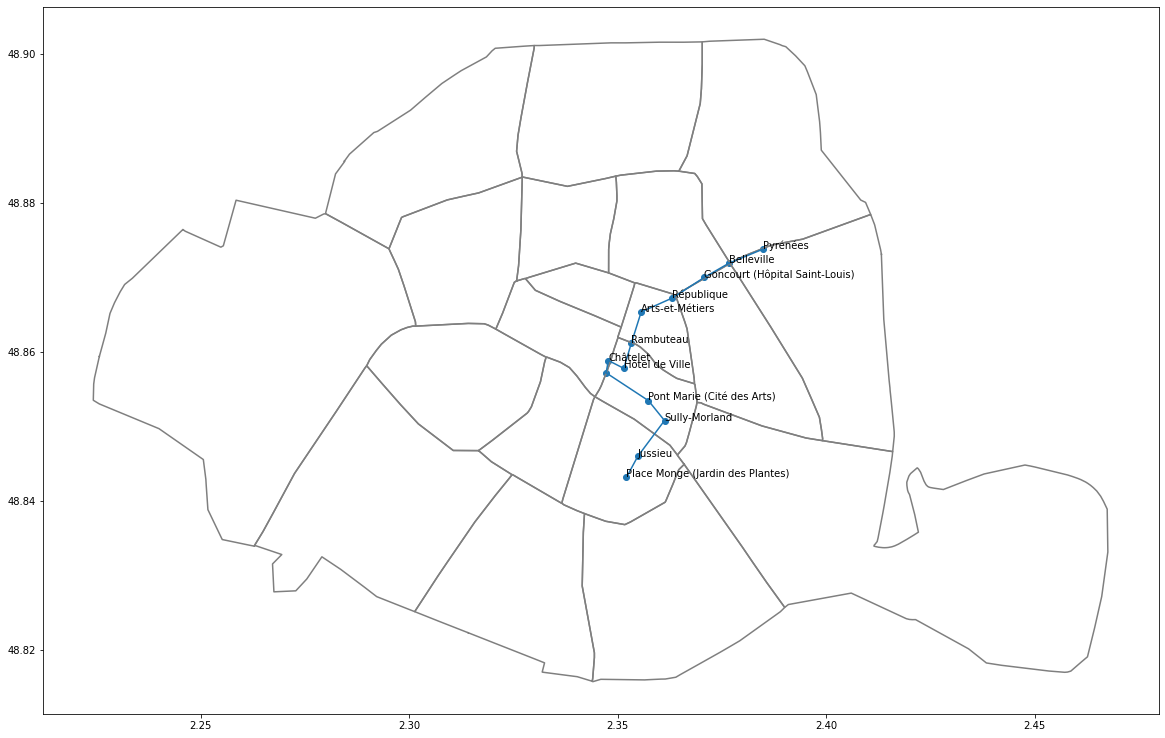

In [9]:
# plotting the districts
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
    plt.plot(coord[:,0],coord[:,1], color='tab:gray')

# plotting the path from 'Place Monge' to 'Pyrénées'
for i in range(L-1, 0, -1) :
    # retrieving data
    # station i
    station_i = path[i]
    pos_i = station_position(station_i)
    name_i = station_name(station_i)
    # next station
    next_station = path[i-1]
    pos_next = station_position(next_station)
    name_next = station_name(next_station)
    
    # plotting
    # plotting path from 'i' to 'next'
    coord = np.array([pos_i, pos_next])
    plt.plot(coord[:, 0], coord[:, 1], color='tab:blue')
    # naming the stations
    if not (i in [L-5]) :
        plt.text(coord[0, 0], coord[0, 1], name_i)
    plt.scatter(coord[0, 0], coord[0, 1], color='tab:blue')

# naming the last station
plt.text(coord[1, 0], coord[1, 1], name_next)
plt.scatter(coord[1, 0], coord[1, 1], color='tab:blue')

# output
plt.show()

## Question 4

Unfortunately a big social protest is taking place in Jussieu and the metro stations with codes 282 and 283 are closed. Find an alternative itinerary to reach the party. Provide its duration and map.

### Hint
Since Jussieu is closed for the whole day, the duration of the connections to and from Jussieu become one day longer (i.e. 86400 seconds). In order to avoid Jussieu modify the nested-dictionary 'durations' and add at the appropriate spots this time delay.


In [10]:
# re-initialize
# setting a new adjancy matrix between nodes
strike_dur = durations.copy()
jussieu = 282
# adding a day for all connections to and from 'Jussieu'
for j in net[jussieu] :
    strike_dur[jussieu][j] += 86400 # connection 'jussieu' --> 'j'
for i in net.keys() :
    if jussieu in net[i] :
        strike_dur[i][jussieu] += 86400 # connection 'i' --> 'jussieu'
    else :
        pass
end = 146 # pyrennees
start = 42 # place_monge

# re-compute
dur_src_strike, previous_nodes_strike = dijkstra(net, strike_dur, start)
min_time = dur_src_strike[end]

# output
print("Minimal time from 'Place Monge' to 'Pyrénées', with strike (s) : {0:.2f}".format(min_time))

Minimal time from 'Place Monge' to 'Pyrénées', with strike (s) : 1322.42


In [11]:
# initialize
pos = end
time = dur_src_strike[end]
path_strike = list()
dates_strike = list()
path_strike.append(end)
dates_strike.append(time)

# compute
while pos != start :
    pos = previous_nodes_strike[pos]
    path_strike.append(pos)
    time = dur_src_strike[pos]
    dates_strike.append(time)

# output
L = len(path_strike)
print("From 'Place Monge' to 'Pyrénées' :\n(with strike)\n-------------------------------------")
for i in range(L-1, -1, -1) :
    print('station : {0:5d} . . . . date : {1:6.1f}'.format(path_strike[i], dates_strike[i]))

From 'Place Monge' to 'Pyrénées' :
(with strike)
-------------------------------------
station :    42 . . . . date :    0.0
station : 13185 . . . . date :   45.0
station : 13183 . . . . date :  175.0
station :   377 . . . . date :  207.0
station :   195 . . . . date :  283.3
station :   345 . . . . date :  346.1
station :    46 . . . . date :  408.2
station :   226 . . . . date :  438.2
station :   120 . . . . date :  511.4
station :   343 . . . . date :  571.9
station :   333 . . . . date :  658.0
station :   334 . . . . date :  800.0
station :   269 . . . . date :  860.0
station :   149 . . . . date :  925.2
station :   404 . . . . date : 1003.1
station : 26502 . . . . date : 1089.6
station :   332 . . . . date : 1165.3
station :   417 . . . . date : 1231.8
station :   146 . . . . date : 1322.4


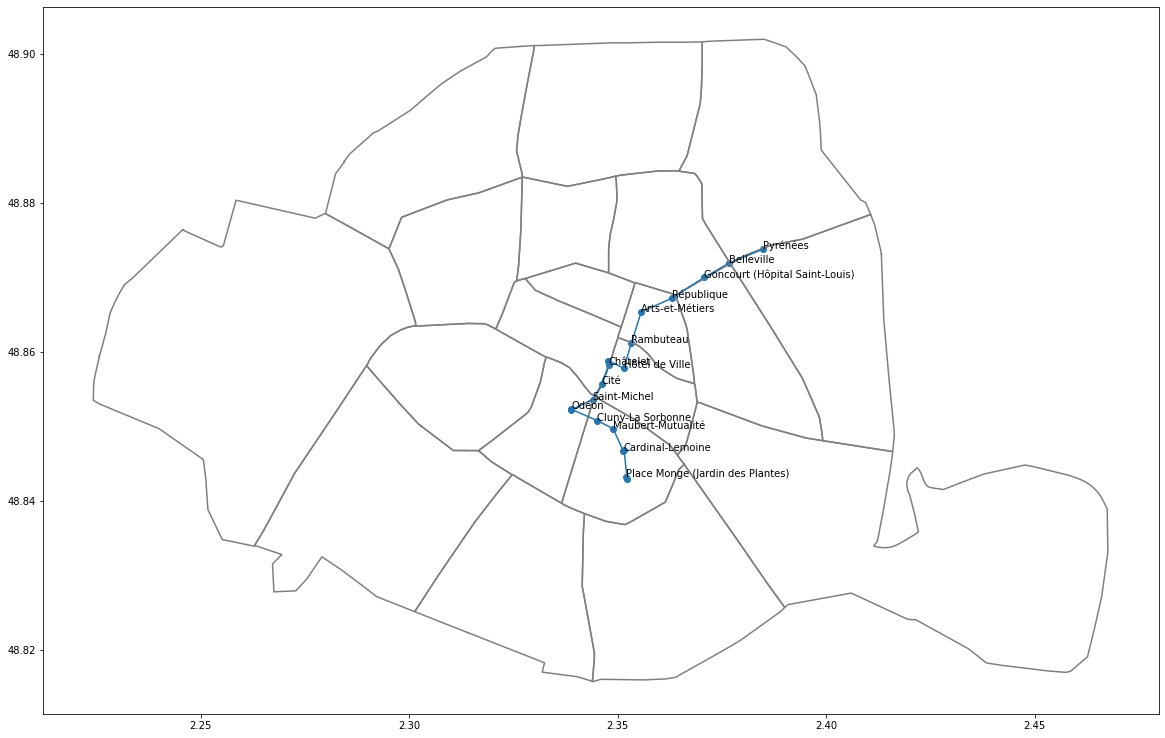

In [12]:
# plotting the districts
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
    plt.plot(coord[:,0],coord[:,1], color='tab:gray')

# plotting the path from 'Place Monge' to 'Pyrénées'
for i in range(L-1, 0, -1) :
    # retrieving data
    # station i
    station_i = path_strike[i]
    pos_i = station_position(station_i)
    name_i = station_name(station_i)
    # next station
    next_station = path_strike[i-1]
    pos_next = station_position(next_station)
    name_next = station_name(next_station)

    # plotting
    # plotting path_strike from 'i' to 'next'
    coord = np.array([pos_i, pos_next])
    plt.plot(coord[:, 0], coord[:, 1], color='tab:blue')
    # naming the stations
    if not (i in [L-2, L-3, L-8, L-12]) :
        plt.text(coord[0, 0], coord[0, 1], name_i)
    plt.scatter(coord[0, 0], coord[0, 1], color='tab:blue')
# naming the last station
plt.text(coord[1, 0], coord[1, 1], name_next)
plt.scatter(coord[1, 0], coord[1, 1], color='tab:blue')

# output
plt.show()

# Part 2 - Further exploration of the Ising model

In this second part, you will be interested in the two-dimensional Ising model.
As a reminder, the Ising model describes a set of spins sitting on the sites
of a given lattice. You will consider the **periodic** two-dimensional square
lattice with $N = L \times L$ sites. The spin sitting on the site $j$ is described by
a variable $\sigma_j = \pm 1$. The energy for
a given configuration $\{ \sigma \}$ of spins is

$$
E(\{\sigma\}) = -J\sum_{\langle ij \rangle} \sigma_i \sigma_j
$$

where $\langle i j \rangle$ indicates that $i$ and $j$ are
nearest-neighbors on the lattice. In the following, you will consider the
ferromagnetic case $J>0$ and use $J=1$ as the unit of energy.
The Ising model has a phase transition at the critical temperature

$$
T_c = \frac{2}{\ln(1+\sqrt{2})} = 2.269185\ldots
$$

## The Glauber algorithm

During the lecture, you have studied three different Monte Carlo algorithms for the Ising model. Here, you will investigate one more: the Glauber algorithm.
Just like the heat-bath it is also a rejection-free
algorithm. The algorithm follows these steps:

1. Pick a random site $i$ on the lattice

2. Flip the spin $\sigma_i$ on site $i$ to $-\sigma_i$ with probability:

   $$
    P^\mathrm{flip}_i = \frac{1}{1 + \exp(\beta \, 2 J \sigma_i h_i)}
   $$
   
   where $h_i$ is the molecular field on the site $i$:
   
   $$
   h_i = \sum_{j \, \in \, \text{neighbors of $i$}} \sigma_j
   $$
   
3. Go back to step 1.

### Question 5

Prove that the Glauber algorithm leads to a sampling of the configurations that follows the Boltzmann distribution.

#### Answer 5

_A proof is expected_

#### Proof

The algorithm is a Markov-chain that jumps from one spin configuration to another at each step. From that results a history of visited configuration of a certain length. The resulting visiting distribution of configurations will converge to a stationary distribution as the length grows.

Lets consider a given configuration $A$ :
$$A = (\sigma_{1}, \sigma_{2}, ..., \sigma_{N})$$
The algorithm jumps from a configuration to another by flipping a *signle* spin. Thus, all accessible configurations can be written as :
$$
\begin{array}{rl}
B_{1} &= (-\sigma_{1}, \sigma_{2}, ..., \sigma_{N}) \\
B_{2} &= (\sigma_{1}, -\sigma_{2}, ..., \sigma_{N}) \\
... & \\
B_{i} &= (\sigma_{1}, ..., -\sigma_{i}, ..., \sigma_{N}) \\
\end{array}
$$
This is $N$ different configurations.
The probability to jump from configuration $A$ to configuration $B_{i}$ is given by :
$$\mathbb{P}(B_{i} \;\vert\; A) = \frac{1}{N} P^\mathrm{flip}_i = \frac{1}{N} \dfrac{1}{1 + \exp(\beta 2 J \sigma_{i} h_{i})}$$

Finally, we can compute the difference in energy between the two configurations :
$$E_{B_{i}} - E_{A} = - J \sum_{\langle j, k \rangle, \; j, k \neq i} \big(\sigma^{B}_{j}\sigma^{B}_{k} - \sigma^{A}_{j}\sigma^{A}_{k} \big) - J \sum_{j \, \in \, \text{neighbors of $i$}} \big(\sigma^{B}_{j}\sigma^{B}_{i} - \sigma^{A}_{j}\sigma^{A}_{i} \big)$$
Where $i$ is a given indice (and not a summation variable). The first sum is zero since beside from spin n°i, all spins are identical between the two configurations. Also, since $\sigma^{B}_{i} = -\sigma^{A}_{i}$, we can continue :
$$E_{B_{i}} - E_{A} = 0 + J \sum_{j \, \in \, \text{neighbors of $i$}} \big(\sigma^{B}_{j} + \sigma^{A}_{j}\big) \sigma^{A}_{i} = 2 J \sigma^{A}_{i} h_{i}$$

Lets consider the Boltzmann distribution :
$$\mathbb{P}(A) = \frac{1}{Z} \exp(-\beta E_{A})$$
Lets compute $\mathbb{P}(B_{i} \;\vert\; A) \mathbb{P}(A)$ :
$$
\begin{array}{rl}
\mathbb{P}(B_{i} \;\vert\; A) \mathbb{P}(A) &= \frac{1}{NZ} \dfrac{1}{1 + e^{\beta 2 J \sigma_{i} h_{i}}} e^{-\beta E_{A}} \\
...                                         &= \frac{1}{NZ} \dfrac{e^{-\beta 2 J \sigma_{i} h_{i}}}{e^{-\beta 2 J \sigma_{i} h_{i}} + 1} e^{-\beta E_{A}} \\
...                                         &= \frac{1}{NZ} \dfrac{1}{1 + e^{-\beta 2 J \sigma_{i} h_{i}}} e^{-\beta E_{A} - \beta 2 J \sigma_{i} h_{i}} \\
\end{array}
$$

Since $-\beta E_{A} - \beta 2 J \sigma_{i} h_{i} = -\beta E_{B_{i}}$, then

$$\mathbb{P}(B_{i} \;\vert\; A) \mathbb{P}(A) = \mathbb{P}(A \;\vert\; B_{i}) \mathbb{P}(B_{i})$$

We have proven that **the Boltzmann distribution satisfies the detailed balance for the Glauver algorithm**, and is a stationary distribution of the Markov chain.
It is easy to prove that the Markov chain of the Glauber algorithm is not reducible (every configuration can be reached in a finite number of steps) and not periodic. Thus **this stable distribution is unique** : it is *the* long-term equilibrium of the algorithm.

**Conclusion : The Bolzmann distribution satisfies the detailed balance for the Glauber algorithm and is the long-term equilibrium distribution.**

### Question 6

Implement the Glauber algorithm and compare your results to those
  obtained with the Wolff algorithm.
  More specifically, use both algorithms to compute: the absolute value of the magnetization,
  the specific heat, the energy and the susceptibility as a function of temperature.
  Use a $6 \times 6$ lattice and 10 temperatures in the range $[0.5, 4.0]$.
  
  The function that implements the Glauber algorithm can have the signature
  ```python
def glauber(config, T)
    # your code
  ```
  where `config` is a spin configuration to be modified by the Glauber algorithm and `T`
  is the temperature. Just like for the heat bath, let the function apply a total of
  $N = L \times L$ proposal moves.
  
  When running
  the Wolff algorithm, use the implementation below. It is an improved version of the algorithm
  that we have used in the lecture that runs a bit faster:

  ```python
def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1
   ```

#### Answer 6

_A code as well as 4 plots showing a comparison between the algorithms are expected._

In [13]:
def glauber(config, T) :
    """Executes L*L moves on lattice 'config' according to the Glauber algorithm at temperature 'T'."""
    J = 1
    beta = T**-1
    L = np.shape(config)[0]
    
    for t in range(L**2) :
        # pick a site
        i, j = np.random.randint(L, size=2)
        spin = config[i, j]
        # compute the field
        h = config[(i+1)%L, j] + config[(i-1)%L, j] + config[i, (j+1)%L] + config[i, (j-1)%L]
        # compute P_flip
        P_flip = 1/(1 + np.exp(beta*2*J*spin*h))
        # flip with P_flip
        if np.random.uniform() < P_flip :
            config[i, j] *= -1
        else :
            pass
    return

def wolff(config, T):
    """Executes L*L moves on lattice 'config' according to the Wolff algorithm at temperature 'T'."""
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]
    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
        config[i,j] *= -1
    return

In [14]:
def compute_energy(config) :
    """Computes the energy of a configuration with J = 1."""
    J=1
    e = 0
    for i in [0, 1] :
        e -= J*np.sum(np.multiply(config, np.roll(config, shift=(i, 1-i), axis=(0, 1))))
    return e


def compute_magnetization(config) :
    """Computes the magnetization of a configuration."""
    m = np.sum(config)
    return m

In [15]:

def monte_carlo(do_step, T, n_steps) :
    """Executes a Monte Carlo simulation on a 6x6 lattice using the Markov chain implemented by the function 'do_step'. Returns sequences for magnetization, susceptibility, energy and specific_heat."""
    # initilalize
    L = 6
    beta = T**-1
    config = np.random.choice([-1, 1], size=(L, L))
    energies = np.zeros(n_steps)
    magnetizations = np.zeros(n_steps)

    # thermalize
    for t in range(3) :
        do_step(config, T)

    # evolve the Markov chain
    for t in range(n_steps) :
        do_step(config, T)
        energies[t] = compute_energy(config)
        magnetizations[t] = compute_magnetization(config)

    # compute the average of the observables acress the sample-path of the Markov chain
    energy = np.mean(energies)
    specific_heat = beta**2/n_steps * np.var(energies)
    magnetization = np.mean(magnetizations)
    susceptibility = beta/n_steps * np.var(np.abs(magnetizations))
    
    return energy, specific_heat, magnetization, susceptibility

In [16]:
# initialize
n_steps = 5000
Ts = np.linspace(0.5, 4., num=10)
es = np.zeros((10, 2)) # energies
cvs = np.zeros((10, 2)) # specific heats
ms = np.zeros((10, 2)) # magnetizations
chis = np.zeros((10, 2)) # susceptibility

In [17]:
# compute
for i in range(10) :
    es[i, 0], cvs[i, 0], ms[i, 0], chis[i, 0] = monte_carlo(glauber, Ts[i], n_steps)
    es[i, 1], cvs[i, 1], ms[i, 1], chis[i, 1] = monte_carlo(wolff, Ts[i], n_steps)

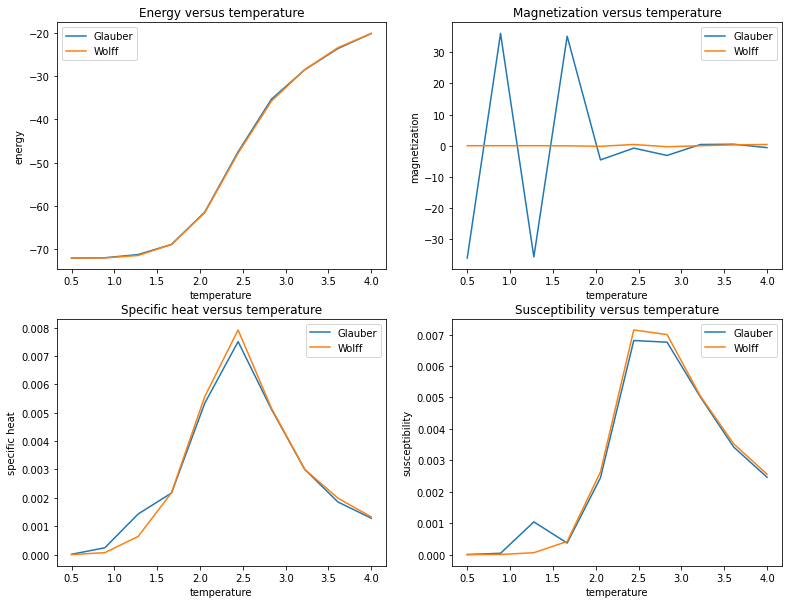

In [18]:
# display

fig = plt.figure(figsize=(13, 10))

# plot energy
ax1 = fig.add_subplot(221)
ax1.plot(Ts, es[:, 0], label='Glauber')
ax1.plot(Ts, es[:, 1], label='Wolff')
ax1.set_xlabel('temperature')
ax1.set_ylabel('energy')
ax1.legend()
ax1.set_title('Energy versus temperature')

# plot specific heat
ax2 = fig.add_subplot(223)
ax2.plot(Ts, cvs[:, 0], label='Glauber')
ax2.plot(Ts, cvs[:, 1], label='Wolff')
ax2.set_xlabel('temperature')
ax2.set_ylabel('specific heat')
ax2.legend()
ax2.set_title('Specific heat versus temperature')

# plot magnetization
ax3 = fig.add_subplot(222)
ax3.plot(Ts, ms[:, 0], label='Glauber')
ax3.plot(Ts, ms[:, 1], label='Wolff')
ax3.set_xlabel('temperature')
ax3.set_ylabel('magnetization')
ax3.legend()
ax3.set_title('Magnetization versus temperature')

# plot susceptibility
ax4 = fig.add_subplot(224)
ax4.plot(Ts, chis[:, 0], label='Glauber')
ax4.plot(Ts, chis[:, 1], label='Wolff')
ax4.set_xlabel('temperature')
ax4.set_ylabel('susceptibility')
ax4.legend()
ax4.set_title('Susceptibility versus temperature')

# output
plt.show()

## Cluster size histogram

In this section, you will investigate the distribution of cluster sizes in the Wolff cluster
algorithm. In particular, you will study what are the cluster sizes that are sampled
in different regimes of the Ising model: low temperature, high temperature and at the critical temperature $T_c$.

### Question 7

Make a small modification to the `wolff` function given above so that it returns
  the size of the cluster that was flipped. Then, create histograms that display the distribution
  of cluster sizes that are flipped during the Monte Carlo sampling. Compute these histograms
  for 3 temperatures: $T = 0.9 T_c, T_c, 1.1 T_c$ for a system of size $32 \times 32$.
  Discuss the results.

#### Answer 7

_A code using your modified `wolff` function is expected, together with 3 histogram plots and a discussion of the results._

In [19]:
def wolff_ret_size(config, T):
    """Executes L*L moves on lattice 'config' according to the Wolff algorithm at temperature 'T'. Returns the size of the cluster that was flipped."""
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    clt_size = 1
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                clt_size += 1
                
        config[i,j] *= -1
    return clt_size

In [20]:
# initialization
Tc = 2 / np.log(1 + np.sqrt(2))
Ts = [0.9*Tc, Tc, 1.1*Tc]
hists = []
n_steps = 5000
L = 32


In [21]:
# compute
for T in Ts :
    hist = []
    config = np.random.choice([-1, 1], size=(L, L))
    # thermalization
    for t in range(3) :
        wolff_ret_size(config, T)
    # evolving the Markov chain
    for t in range(n_steps) :
        clt_size = wolff_ret_size(config, T)
        hist.append(clt_size)
    hists.append(hist)


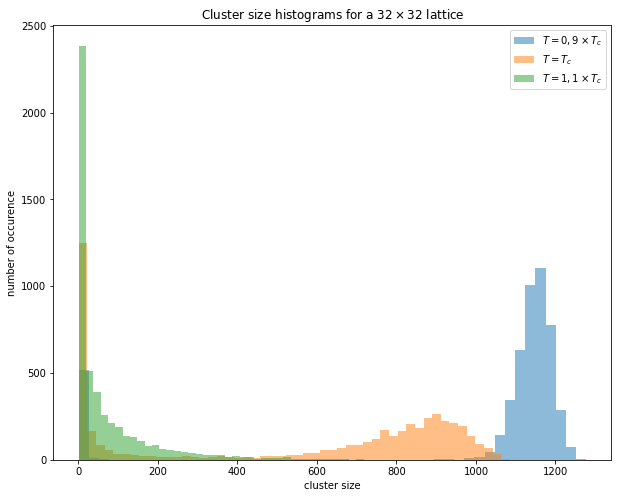

In [22]:
fig = plt.figure(figsize=(10, 8))
plt.title('Cluster size histograms for a $32 \\times 32$ lattice')

plt.hist(hists[0], bins=50, label='$T = 0,9 \\times T_c$', alpha=0.5)
plt.hist(hists[1], bins=50, label='$T = T_c$', alpha=0.5)
plt.hist(hists[2], bins=50, label='$T = 1,1 \\times T_c$', alpha=0.5)
plt.xlabel('cluster size')
plt.ylabel('number of occurence')
plt.legend()

# output
plt.show()

## Spin-spin correlations

In this last section, you will compute and discuss the spin-spin correlation function.
It is defined by the following average

$$
  C(r) = \langle \sigma_i \; \sigma_{i+r} \rangle
$$

This function measures how the spin at site $i$ and the spin at site $i+r$ are correlated.
In the following, you will focus on the case where $r$ is a vector along the horizontal
axis. In other words, the site $i$ and the site $i+r$ are on the same row. The correlation
function $C(r)$ does not depend on $i$ because of the translational symmetry of the lattice.
On an infinite lattice and not too far from the critical temperature, it can be shown that the correlation function has the following
behavior at large $r$:
  
$$
 C(r) \sim A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
$$

where $\xi$ is the correlation length and $A, S$ are constants. Onsager has shown that
the critical exponent $\eta = 1/4$.

### Question 8

Write a function that computes the correlation function $C(r)$ using the Wolff cluster
  Monte Carlo algorithm on a $32 \times 32$ lattice.
  Compute $C(r)$ at two temperatures: $T = 0.8 T_c$ and $T = 1.2 T_c$. Discuss the qualitative differences
  between these results (using plots of $C(r)$ in both cases).

#### Answer 8

_A code as well as two plots with a discussion of the results are expected._

In [23]:
 
def monte_carlo_ret_corr(T, n_steps) :
    """Executes a Monte Carlo simulation on a 6x6 lattice using the Markov chain implemented by the function 'do_step'. Returns the correlation function."""
    # initilalize
    L = 32
    beta = T**-1
    config = np.random.choice([-1, 1], size=(L, L))
    correlations = np.zeros((n_steps, 32))

    # thermalization
    for t in range(3) :
        wolff(config, T)

    # evolving the Markov chain
    for t in range(n_steps) :
        wolff(config, T)
        correlations[t, :] = config[0, 0] * config[0, :]

    # computing the average of the observables acress the sample-path of the Markov chain
    correlation = np.mean(correlations, axis=0)
    
    return correlation

In [24]:
# initialize
n_steps = 5000
Ts = [0.8*Tc, 1.2*Tc]
rs = np.arange(32)
corr = np.zeros((32, 2))

In [25]:
# compute
for i in range(2) :
    T = Ts[i]
    correlation = monte_carlo_ret_corr(T, n_steps)
    corr[:, i] = correlation    

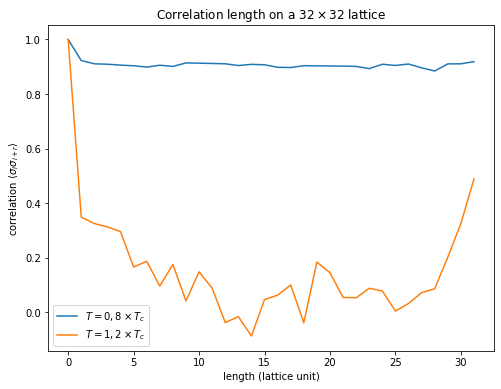

In [26]:
fig = plt.figure(figsize=(8, 6))

plt.title('Correlation length on a $32 \\times 32$ lattice')
plt.plot(corr[:, 0], label='$T = 0,8 \\times T_c$')
plt.plot(corr[:, 1], label='$T = 1,2 \\times T_c$')
plt.xlabel('length (lattice unit)')
plt.ylabel('correlation $\\langle \\sigma_i \\sigma_{i+r} \\rangle$')
plt.legend()

# output
plt.show()

### Question 9

Compute the correlation function $C(r)$ for 10 temperatures in the range
  $[T_c - 0.3, T_c + 0.3]$. Fit these correlation functions with a function of the form
  
  $$
    f_\mathrm{fit}(r) = A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
  $$

  where $A$, $S$, $\eta$ and $\xi$ are fitting parameters. Note that even though we know that $\eta = 1/4$
  from the Onsager solution, we will not assume we know that value and you should use $\eta$ as one of the
  fitting parameters. Create plots that show $C(r)$ and its fits.
  
#### Hints
  
  - Because we work with finite lattices with periodic boundary conditions, be careful
    to only use *half* of the data in $C(r)$.
    
  - The fitting function is in principle only valid for large $r$. In practice, you can
    just **ignore the first point** (at $r=0$) of the data in the fit.
      
  - You can use `scipy.optimize` to do the fits. Here is an example of how it works:
  
    ```python
    import scipy.optimize
    
    # fit function
    def fit_function(x, a, b, c):
      return # some function of (x,a,b,c)

    # data obtained by Monte Carlo
    x_values = ...
    y_values = ...
    
    # do the fit
    a, b, c = scipy.optimize.curve_fit(fit_function, x_values, y_values, bounds=[0,20])[0]
    
    ```
   
    where we have specified that the fit should only consider values for $a,b,c$ in $[0,20]$.

#### Answer 9

_A code together with 10 plots is expected._


In [27]:
# initialize
n_steps = 5000
Ts = np.linspace(Tc-0.3, Tc+0.3, num=10)
rs = np.arange(32)
corr = np.zeros((32, 10))

In [28]:
# compute
for i in range(10) :
    T = Ts[i]
    correlation = monte_carlo_ret_corr(T, n_steps)
    corr[:, i] = correlation

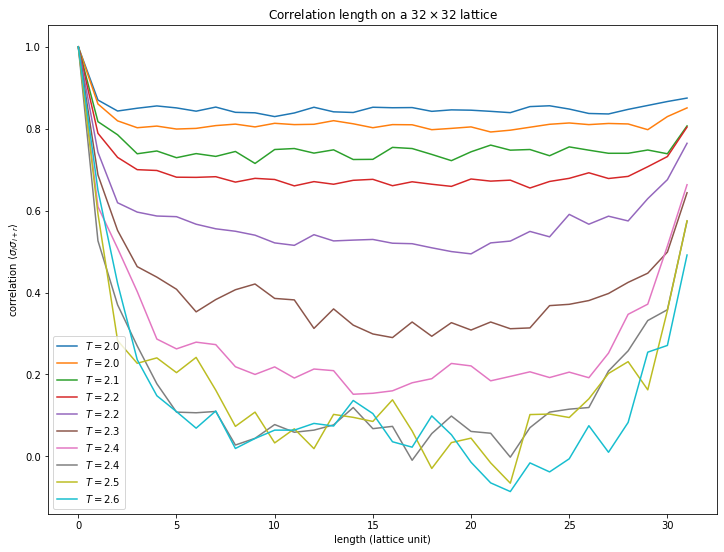

In [29]:
# display

fig = plt.figure(figsize=(12, 9))

plt.title('Correlation length on a $32 \\times 32$ lattice')
for i in range(10) :
    plt.plot(corr[:, i], label='$T = {0:1.2}$'.format(Ts[i]))
plt.xlabel('length (lattice unit)')
plt.ylabel('correlation $\\langle \\sigma_i \\sigma_{i+r} \\rangle$')
plt.legend()

# output
plt.show()

In [30]:
# initialize

As = np.zeros(10)
Ss = np.zeros(10)
etas = np.zeros(10)
xis = np.zeros(10)

def cutoff_power_law(r, A, S, eta, xi) :
    return A * np.exp(-r/xi) / (r/xi)**(1/eta) + S
cutoff_vect = np.vectorize(cutoff_power_law)

In [31]:
# compute
x_values = rs[1:17]
for i in range(10) :
    # fit values
    y_values = corr[1:17, i]
    As[i], Ss[i], etas[i], xis[i] = scipy.optimize.curve_fit(cutoff_power_law, x_values, y_values, p0=[1, 1, 3, 1], bounds=[0, 20])[0]

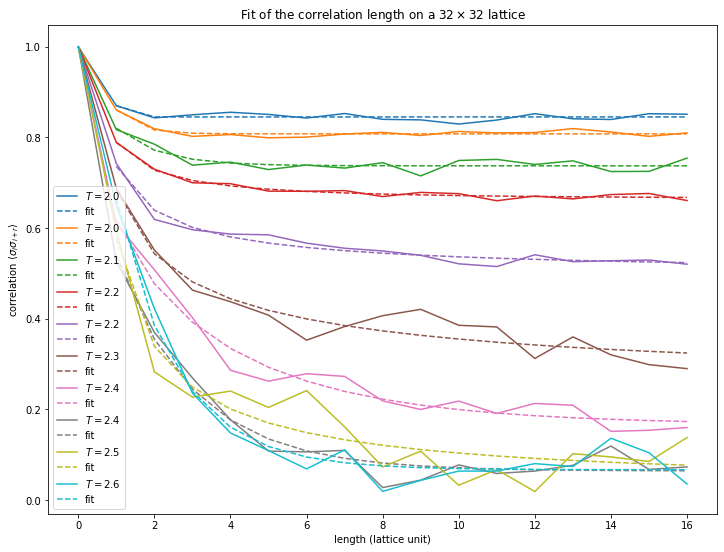

In [32]:
# display

plt.close('all')
fig = plt.figure(figsize=(12, 9))

rs = np.arange(17)
plt.title('Fit of the correlation length on a $32 \\times 32$ lattice')
for i in range(10) :
    a = plt.plot(corr[:17, i], label='$T = {0:1.2}$'.format(Ts[i]))
    col = a[0].get_color()
    plt.plot(rs[1:], cutoff_vect(rs[1:], As[i], Ss[i], etas[i], xis[i]), ls='--', label='fit', color=col)
plt.xlabel('length (lattice unit)')
plt.ylabel('correlation $\\langle \\sigma_i \\sigma_{i+r} \\rangle$')
plt.legend()

# output
plt.show()

 ### Question 10
 
Discuss the behavior of the fitting parameters $\xi, \eta, S$ in connection with their physical meaning.

#### Answer 10

_A discussion of the results is expected. You may want to generate additional plots to support your discussion._

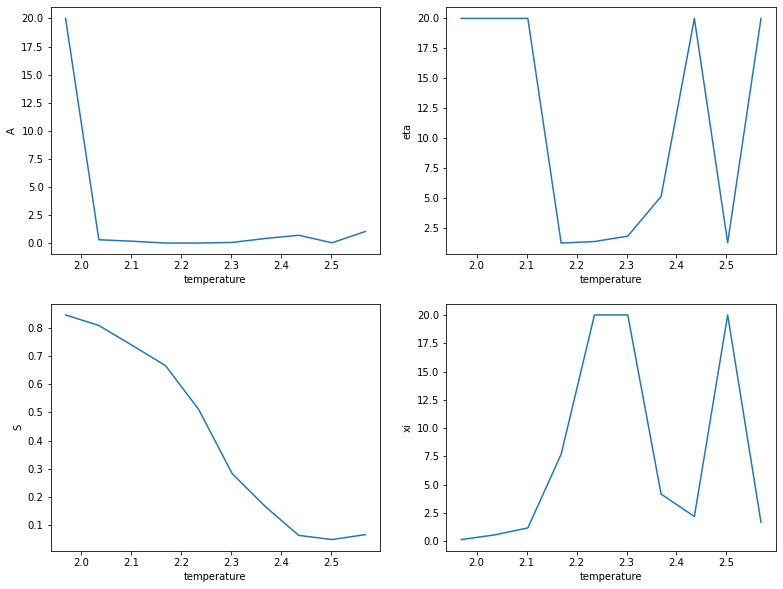

In [34]:
# display

fig = plt.figure(figsize=(13, 10))

# A
ax1 = fig.add_subplot(221)
ax1.plot(Ts, As, label='A')
ax1.set_xlabel('temperature')
ax1.set_ylabel('A')

# S
ax2 = fig.add_subplot(223)
ax2.plot(Ts, Ss, label='S')
ax2.set_xlabel('temperature')
ax2.set_ylabel('S')

# eta
ax3 = fig.add_subplot(222)
ax3.plot(Ts, etas, label='eta')
ax3.set_xlabel('temperature')
ax3.set_ylabel('eta')

# xi
ax4 = fig.add_subplot(224)
ax4.plot(Ts, xis, label='xi')
ax4.set_xlabel('temperature')
ax4.set_ylabel('xi')

# output
plt.show()

We can make a few comments on the values found here :
- the parameter `A` is rather nicely fitted, specially for temperatures above $T_c$,
- `S` is also precisely fitted, both above and below $T_c$. It displays the right behavior as it corresponds to the magnetization (= correlation at infinity),
- `eta` is not very nicely fitted, and fluctuates a lot. Requirering a better convergence here would be necessary, knowing it should converge to $\eta = 4$,
- finally, `xi` is most of the times nicely approximated, the divergence near the phase transition is visible (`xi` is bigger for $T \approx T_c$).

We see that the noisy parameters (`eta` and `xi`) are indeed not very influencial on the overall aspect of the fitting curve, and the fit are always visually valid.
